In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model, datasets
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [21]:
def incrementer(start, end, step):
    current = start
    while current < end:
        yield current
        current += step

def get_avaible_dates(from_date, to_date):
    avaible_dates = []
    for date in incrementer(from_date, to_date, timedelta(days=1)):
        avaible_dates.append(date)
    return avaible_dates

def get_retrain_flags(dates, frequency):
    flags = []
    for i in range(0, len(dates)):
        if i % frequency == 0:
            flags.append(True)
        else:
            flags.append(False)
    return flags

def rolling_prediction(data_all, all_available_dates, retrain_flags, model):
    collected_preds = []
    for available_date, retrain_flag in zip(all_available_dates, retrain_flags):

        target_date = available_date + timedelta(days = 1)
        print(target_date)

        train = data_all[data_all['date'] < str(available_date)].copy()
        test = data_all[data_all['date'] == str(target_date)].copy()
        
        train = train.dropna()
        
        non_input_features = ['date', 'target']
        
        if retrain_flag is True:
            model = model.fit(train.drop(non_input_features, axis=1), train['target'])
        
        test['prediction'] = model.predict(test.drop(non_input_features, axis=1))
        
        collected_preds.append(test[['date','tick', 'target', 'prediction']])
        
    collected_preds = pd.concat(collected_preds)        
    return collected_preds
        
def predict(data_all, from_date, to_date, retrain_how_often_days):
    
    model = GradientBoostingRegressor(loss='ls', n_estimators=100, max_depth=5, \
                                      subsample=0.8, min_samples_leaf=10, learning_rate=0.1, \
                                      random_state=2016, verbose = 0)
#     model = linear_model.LogisticRegression(C=1e5)
#     model = KNeighborsClassifier(n_neighbors=5)

    all_available_dates = get_avaible_dates(from_date, to_date)        
    retrain_flags = get_retrain_flags(all_available_dates, retrain_how_often_days)
    
    return rolling_prediction(data_all, all_available_dates, retrain_flags, model)



def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

2016-01-10
2016-01-11
2016-01-12
2016-01-13
2016-01-14
2016-01-15
2016-01-16
2016-01-17
2016-01-18
2016-01-19
2016-01-20
2016-01-21
2016-01-22
2016-01-23
2016-01-24
2016-01-25
2016-01-26
2016-01-27
2016-01-28
2016-01-29
2016-01-30
2016-01-31
2016-02-01
2016-02-02
2016-02-03
2016-02-04
2016-02-05
2016-02-06
2016-02-07
2016-02-08
2016-02-09
2016-02-10
2016-02-11
2016-02-12
2016-02-13
2016-02-14
2016-02-15
2016-02-16
2016-02-17
2016-02-18
2016-02-19
2016-02-20
2016-02-21
2016-02-22
2016-02-23
2016-02-24
2016-02-25
2016-02-26
2016-02-27
2016-02-28
2016-02-29
2016-03-01
2016-03-02
2016-03-03
2016-03-04
2016-03-05
2016-03-06
2016-03-07
2016-03-08
2016-03-09
2016-03-10
2016-03-11
2016-03-12
2016-03-13
2016-03-14
2016-03-15
2016-03-16
2016-03-17
2016-03-18
2016-03-19
2016-03-20
2016-03-21
2016-03-22
2016-03-23
2016-03-24
2016-03-25
2016-03-26
2016-03-27
2016-03-28
2016-03-29
2016-03-30
2016-03-31
2016-04-01
2016-04-02
2016-04-03
2016-04-04
2016-04-05
2016-04-06
2016-04-07
2016-04-08
2016-04-09

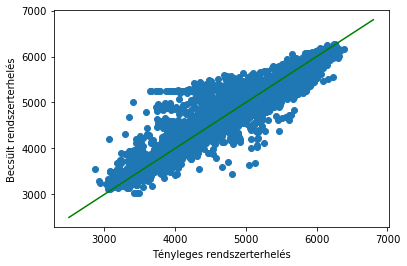

MAPE: 2.8074124350648093 %


In [22]:
data = pd.read_csv('Data_Expansion.csv')
# data = pd.read_csv('processed_detailedweather.csv')
data.__delitem__('export')
data.__delitem__('import')

#Krisz:
TARGET = 'system_load'
data['target'] = data[TARGET].copy()
data.__delitem__(TARGET)
# data.__delitem__('avg_sysload')
# data.__delitem__('avg_import')
# data.__delitem__('avg_export')
# data.__delitem__('std_sysload')
# data.__delitem__('std_import')
# data.__delitem__('std_export')
# data.__delitem__('max')
# data.__delitem__('min')
# data.__delitem__('rain')
# data.__delitem__('snow')
# data.__delitem__('avg_max')
# data.__delitem__('avg_min') 
    
for x in [24,48,96,168]:
    data["Lag"+str(x)]=data['target'].shift(x)   
    
preds = predict(data, from_date = date(2016, 1, 9), to_date = date(2017, 2, 26), retrain_how_often_days = 7)
    
plt.scatter(preds['target'],preds['prediction'])
plt.xlabel('Tényleges rendszerterhelés')
plt.ylabel('Becsült rendszerterhelés')
plt.plot([2500,6800],[2500,6800],color="green")
plt.show()
    
print('MAPE: {} %'.format(mape(preds['target'], preds['prediction'])))    

In [17]:
#1-2 rossz
#3    GBM, 1 napi, idojaras, mean_std,       : 3.3839%
#4    GBM, 1 napi, idojaras,         ,       : 3.3034%
#5    GBM, 1 napi,         ,         ,       : 6.0964%
#6    GBM, 1 napi,         ,         , shift : 2.5854%
#7    GBM, 1 napi, idojaras, mean_std, shift : 2.6736%
#8    GBM, 1 napi, idojaras,         , shift : 2.6748%
#9 logreg: 3 napi,         ,         , shift : 6.81698% - 4+ oras futas 
#10   KNN: 1 napi,         ,         , shift : 4.54698% - leggyorsabb
#11   KNN: 1 napi, idojaras, mean_std, shift : 4.8214%
#12   KNN: 1 napi, idojaras,         , shift : 4.5426%
#13   KNN: 1 napi,         , mean_std, shift : 4.8207%
#14   KNN: 1 napi, idojaras, mean_std,       : 9.12989%
#15   KNN: 1 napi,         ,         ,       : 7.6313%
#16   GBM: 1 napi,  orasido, mean_std, shift : 3.15309% - Kapott idoadatokkal
#17   GBM: 1 napi,  orasido,         ,       : 3.57067%


In [6]:
data

,date,tick,max,min,rain,snow,avg_max,avg_min,day_of_week,holiday,...,avg_export,avg_import,std_sysload,std_export,std_import,target,Lag24,Lag48,Lag96,Lag168
0,2016-01-01,0,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,4071.0,NaN,NaN,NaN,NaN
1,2016-01-01,1,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3873.0,NaN,NaN,NaN,NaN
2,2016-01-01,2,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3581.0,NaN,NaN,NaN,NaN
3,2016-01-01,3,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3356.0,NaN,NaN,NaN,NaN
4,2016-01-01,4,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3294.0,NaN,NaN,NaN,NaN
5,2016-01-01,5,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3302.0,NaN,NaN,NaN,NaN
6,2016-01-01,6,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3375.0,NaN,NaN,NaN,NaN
7,2016-01-01,7,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3436.0,NaN,NaN,NaN,NaN
8,2016-01-01,8,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3565.0,NaN,NaN,NaN,NaN
9,2016-01-01,9,-3,-10,0,0.0,2,-2,4.0,1,...,883.6,2535.3,836.2,568.8,307.2,3755.0,NaN,NaN,NaN,NaN
